# Домашнее задание 3. VAE + NF + VAPNEV

### Загрузка данных
В данном задании вам предстоит снова работать с CelebA, но уже 64x64

Решением домашки является архив с использованными тетрадками/модулями, а так же .pdf файл с отчетом по проделанной работе по каждому пункту задачи. В нем необходимо описать какие эксперименты вы производили чтобы получить результат который вы получили, а так же обосновать почему вы решили использовать штуки которые вы использовали (например, дополнительные лоссы для стабилизации, разные виды потоков, разные хаки для вае)



In [1]:
import fileinput
from math import log
from os import makedirs
from os.path import exists, join

import numpy as np
import requests
import torch
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms, utils
from tqdm.auto import trange, tqdm

from homework_3.glow import Glow

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%%capture

! pip install --upgrade --no-cache-dir gdown

In [3]:
url = "https://raw.githubusercontent.com/vpozdnyakov/DeepGenerativeModels/spring-2022/utils/datasets/celeba.py"
if not exists("celeba.py"):
    with open("celeba.py", "wb") as f:
        f.write(requests.get(url).content)

for line in fileinput.input("celeba.py", inplace=True):
    if fileinput.filelineno() not in [45, 46]:
        print(line[:-1])
        continue
    if fileinput.filelineno() == 45:
        corrected_line = "                download_url = 'https://drive.google.com/file/d/17NNnHn1RyPPmb4iQqIGJ2XFulfwyW1Sh/view?usp=sharing'"
    else:
        corrected_line = "                gdown.download(download_url, download_path, quiet=False, fuzzy=True)"
    print(corrected_line)

url = "https://raw.githubusercontent.com/vpozdnyakov/DeepGenerativeModels/spring-2022/data/celeba/list_attr_celeba.txt"
if not exists("list_attr_celeba.txt"):
    with open("list_attr_celeba.txt", "wb") as f:
        f.write(requests.get(url).content)

from celeba import CelebADataset

Мы будем использовать урезанный датасет (`crop=True`) для быстрой загрузки на диск.

Для обучения модели вам нужно будет загрузить полную версию датасета.

Перед отправкой тетрадки в автопроверку ***ПРОВЕРЬТЕ*** что `crop=True`, иначе ваше решение будет таймаутиться

In [4]:
class CelebaCustomDataset(CelebADataset):
    def __getitem__(self, idx):
        image, target = super().__getitem__(idx)
        return image


transform = transforms.Compose(
    [
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

dataset = CelebaCustomDataset(transform=transform, attr_file_path="list_attr_celeba.txt", crop=True)
dataset[0].shape

torch.Size([3, 64, 64])

### Визуализация датасета

In [5]:
def plot_img(img):
    plt.imshow(img.permute(1, 2, 0))
    plt.axis("off")

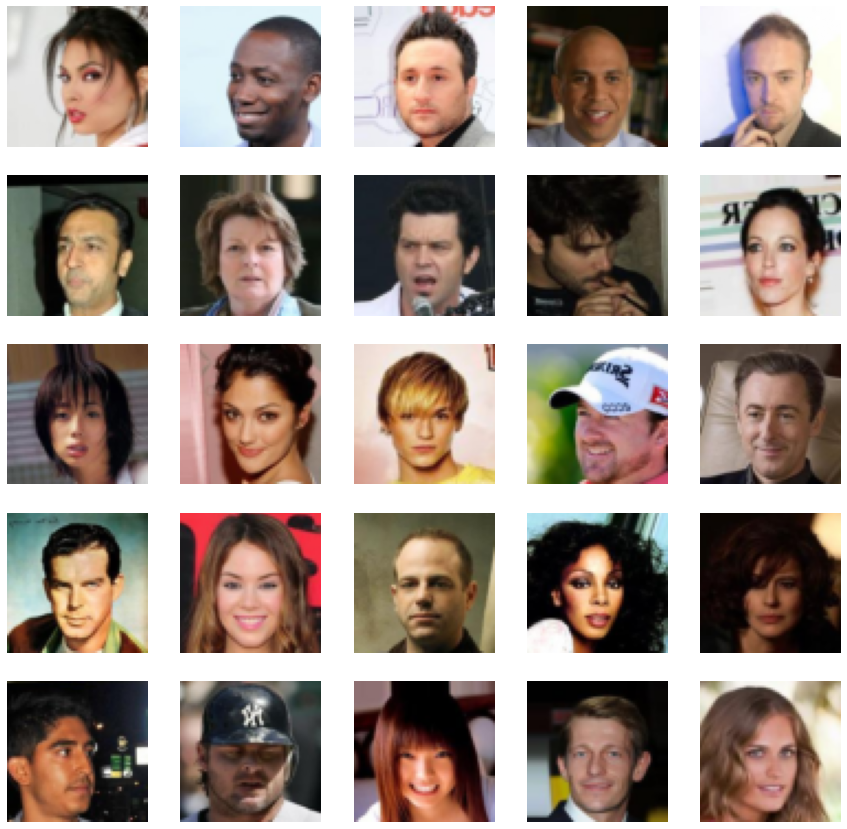

In [6]:
plt.figure(figsize=(15, 15))

for i in range(25):
    img = dataset[np.random.randint(len(dataset))]
    plt.subplot(5, 5, i + 1)
    plot_img(img)

plt.show()

In [7]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

### Задача 1 (4/10 балла). Построить и обучить нормпоток на CelebA 64x64

Здесь нужно обучить нормпоток до нормального (трешхолды будут позже) качества, померить FID и Negative Log Likelihood и запомнить для будущего сравнения

Внутри потока можно использовать все что вы хотите, Coupling/Autoregressive/Linear слои, любые трансформации и все что вам приходит в голову. Но все что вы используете - напишите сами, без копипаста.

Можно использовать как и сверточные потоки (будут лучше, но сложнее писать), так и линейные (будут хуже), развернув селебу в один вектор.

В принципе можно использовать тот код который уже есть в репозитории курса, но он довольно плохой и неэффективный) Лучше написать свой

In [12]:
def calc_size(net):
    param_size = 0
    for param in net.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in net.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    gen_size = (param_size + buffer_size) / 1024**2
    return gen_size

In [10]:
CHECKPOINT_DIR = "checkpoints"
SAMPLES_DIR = "samples"
makedirs(CHECKPOINT_DIR, exist_ok=True)
makedirs(SAMPLES_DIR, exist_ok=True)


def calc_loss(log_p, log_det, n_bins, image_size):
    n_pixel = image_size * image_size * 3

    loss = -log(n_bins) * n_pixel
    loss += log_det + log_p

    return (-loss / (log(2) * n_pixel)).mean()


def train_celeba(model, n_epochs: int = 5, lr: float = 1e-4, batch_size: int = 16, n_bits: int = 5):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    model.train()

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    n_bins = 2.0**n_bits

    z_noise = model.prepare_sample_noise(n_samples=25, img_size=64)
    z_noise = [it.to(device) for it in z_noise]

    model.eval()
    with torch.no_grad():
        sampled_images = model.reverse(z_noise).detach().cpu()
    utils.save_image(
        sampled_images, join(SAMPLES_DIR, f"epoch_0.png"), normalize=True, value_range=(-0.5, 0.5), nrow=5, padding=5
    )

    for e in trange(n_epochs, desc="Epoch"):
        with tqdm(dataloader, desc="Training", leave=False) as pbar:
            model.train()
            for images in pbar:
                images = images.to(device) * 255

                if n_bits < 8:
                    images = torch.floor(images / 2 ** (8 - n_bits))

                images = images / n_bins - 0.5

                log_p, log_det, _ = model(images + torch.rand_like(images) / n_bins)
                log_det = log_det.mean()
                loss = calc_loss(log_p, log_det, n_bits, images.shape[-1])

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                pbar.set_postfix({"loss": loss.item()})

        torch.save(model.state_dict(), join(CHECKPOINT_DIR, f"epoch_{e + 1}.ckpt"))

        model.eval()
        with torch.no_grad():
            sampled_images = model.reverse(z_noise).detach().cpu()
        utils.save_image(
            sampled_images,
            join(SAMPLES_DIR, f"epoch_{e + 1}.png"),
            normalize=True,
            value_range=(-0.5, 0.5),
            nrow=5,
            padding=5,
        )

In [15]:
glow_celeba = Glow(k_flow=32, l_block=4, n_filters=128).to(device)
print(f"model size: {calc_size(glow_celeba):.3f} MB")
train_celeba(glow_celeba)

model size: 55.877 MB


KeyboardInterrupt: 

### Задача 2 (2/10 балла). Построить и обучить VAE на CelebA 64x64

Здесь нужно обучить VAE до нормального (трешхолды будут позже) качества, померить FID и запомнить для будущего сравнения. 

В принципе можно использовать тот код который уже есть в репозитории курса, но лучше написать свой

Ради интереса, ваше вае тоже можно потестировать на маленьких датасетах


In [ ]:
# YOUR CODE HERE

### Задача 3 (6/10 балла). 

#### Задача 3.1 (4/10 балла) Построить и обучить VAPNEV на CelebA 64x64

Здесь нужно прочитать [статью про VAPNEV](https://arxiv.org/pdf/1611.05209.pdf), обучить его до нормального (трешхолды будут позже) качества, померить FID и запомнить для будущего сравнения. 

#### Задача 3.2 (2/10 балла). Построить и обучить conditional VAPNEV на CelebA 64x64

Вроде понятно из текста задачи. Что такое conditional VAPNEV, читайте в статье

In [ ]:
# YOUR CODE HERE

### Задача 4. (1/10 балла) Анализ

* Анализ латентного пространства и визуально качественный результат - **1 балл**
1. Посмотрите у какой модели получается лучшая интерполяция в латентном пространстве
2. Попробуйте взять внешнюю картинку (не из селебы), отмапить ее с латентное пространство и покажите ближайшие к ней.
3. Покажите самый смешной результат генерации который у вас получался

In [ ]:
# YOUR CODE HERE

### Задача 0. Отчет

Чтобы получить полный балл за каждый из пунктов вам нужно включить в отчет (который сдатеся отдельно в виде pdf) примеры (лучше - много примеров) генерации вашей модели. 

Сравните результаты разных моделей, попробуйте обьяснить почему одна сработала лучше чем другая.